## Principal Component Analysis
#### Gavin Daves, Rice University
#### INDE 577, Dr. Randy Davila

In this notebook, we will utilize PCA in Python and use the model(s) we create on the Spotify dataset.

In [108]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys




sns.set_theme()

In [109]:
# Loading the data

# Add the top-level directory to the system path
sys.path.append('../../')

# Load the data
import clean_data as sd

df = sd.get_df()

# Filter by genre

classical = df[df['track_genre'] == 'classical']
hiphop = df[df['track_genre'] == 'hip-hop']
black_metal = df[df['track_genre'] == 'black-metal']

comb = pd.concat([classical, hiphop, black_metal])

### Background

Let's revisit the problem we addressed in the KNN Notebook. In the KNN notebook, we wanted to take different audio metric data of three distinct genres and train a KNN model to classify a songs genre (classical, hip-hop, and black metal).

In the model we built, there was quite a few features. So, we will explore if we can use PCA to make the model less complex and preserve accuracy.

Recall the KNN model we built:

Accuracy: 0.9554794520547946
              precision    recall  f1-score   support

 black-metal       0.96      0.98      0.97       251
   classical       0.95      0.97      0.96       190
     hip-hop       0.95      0.90      0.92       143

    accuracy                           0.96       584
   macro avg       0.95      0.95      0.95       584
weighted avg       0.96      0.96      0.96       584



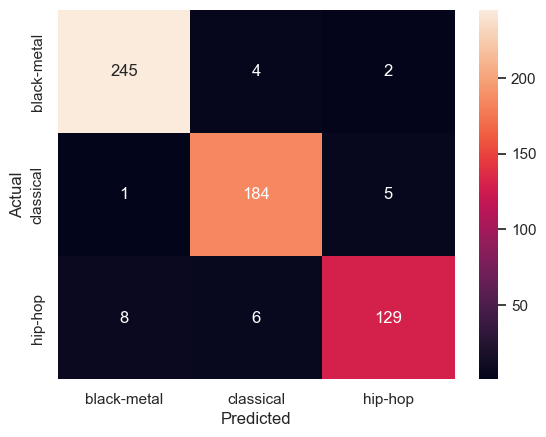

In [110]:
# Build KNN model

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

# Prepare the data

X = comb[['danceability', 'energy', 'loudness', 
          'speechiness', 'acousticness', 'instrumentalness', 
          'liveness', 'valence', 'tempo']]
y = comb['track_genre']

# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)

# Scale the data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Evaluate the model

print('Accuracy:', knn.score(X_test, y_test))

y_pred = knn.predict(X_test)

confusion_matrix = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames = ['Predicted'])
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()

Let's now apply PCA at different numbers of components, formulate models with those components, and measure each model's accuracy:

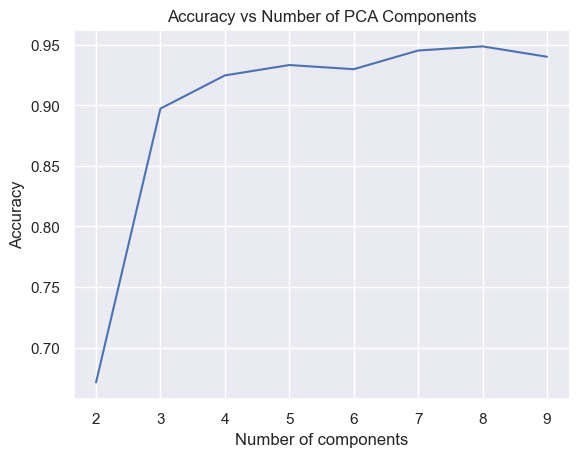

In [111]:
# Apply PCA at different numbers of components and plot accuracy

accs = []

for i in range(2, 10):
       pca = PCA(n_components=i)
       X_copy = pca.fit_transform(X)
       X_train, X_test, y_train, y_test = train_test_split(X_copy, y, test_size=0.25, random_state=50)
       scaler = StandardScaler()
       X_train = scaler.fit_transform(X_train)
       X_test = scaler.transform(X_test)
       knn = KNeighborsClassifier(n_neighbors=5)
       knn.fit(X_train, y_train)
       y_pred = knn.predict(X_test)
       accs.append(accuracy_score(y_test, y_pred))


plt.plot(range(2, 10), accs)
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of PCA Components')
plt.show()

### Picking the Most Efficient Dimension

As can be seen in the plot above, the general trend of the graph is as the number of components increase, the accuracy of the model increases. However, at some point, it may be better to sacrifice a bit of accuracy for increased efficiency (less variables/total components). We can see that at 5 components, there accuracy is a little under .95, and as the model increases in size, the accuracy converges at around .95. So, my choice for the most efficient number of components is 5.

Accuracy: 0.9332191780821918
              precision    recall  f1-score   support

 black-metal       0.96      0.94      0.95       251
   classical       0.93      0.97      0.95       190
     hip-hop       0.88      0.87      0.88       143

    accuracy                           0.93       584
   macro avg       0.93      0.93      0.93       584
weighted avg       0.93      0.93      0.93       584



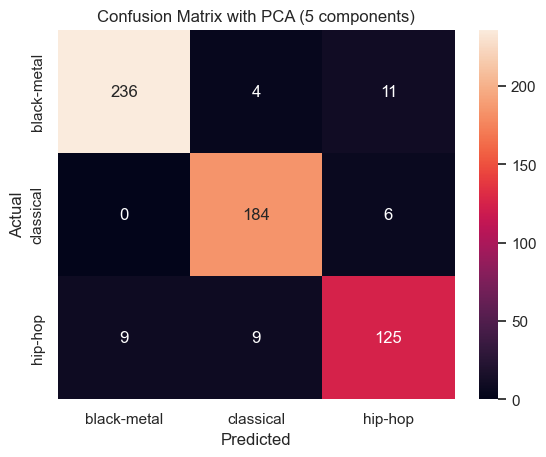

In [112]:
# Find the most efficient number of components

best_amount = 5

pca = PCA(n_components=best_amount)
X = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print('Accuracy:', knn.score(X_test, y_test))

# Evaluate the best model

plt.show()

y_pred = knn.predict(X_test)

confusion_matrix = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames = ['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix with PCA (5 components)')
print(classification_report(y_test, y_pred))

### Error Analysis

As can be seen in the classification report, the accuracy is slightly lower, but with 4 less components. So, if efficiency is imperative, PCA can be used to (mostly) preserve accuracy and decrease the size of the model. 